In [1]:
using Pkg

Pkg.activate("../..")

projectdir_static = dirname(Base.active_project())

projectdirx(args...) = joinpath(projectdir_static, args...)

# Generate functions to access the path of default subdirectories.
for dir_type ∈ ("data", "src", "plots", "scripts", "papers")
    function_name = Symbol(dir_type * "dirx")
    @eval begin
        $function_name(args...) = projectdirx($dir_type, args...)
    end
end

using DrWatson

@quickactivate "GRNEvoContingencyAnalysis"

projectname()

  Activating project at `~/Documents/GRNEvoContingency`


  Activating project at `~/Documents/GRNEvoContingency/notebooks`


"GRNEvoContingencyAnalysis"

In [2]:
include(srcdirx("Evolution.jl"))
include(srcdirx("FitnessFunctions.jl"))

include(srcdirx("Visualization.jl"))

include(srcdirx("DynamicalClustering.jl"))
include(srcdirx("DataProcessing.jl"))
include(srcdirx("MinimalNetworks.jl"))

include(srcdirx("TrajectoryAnalysis.jl"))
include(srcdirx("ConvenienceFunctions.jl"))
include(srcdirx("Epistasis.jl"))
include(srcdirx("LearningFunctions.jl"))

include(srcdirx("GRNVisualization.jl"))
include(srcdirx("AnalysisVisualization.jl"))

include(srcdirx("PhenotypeEvaluation.jl"))
include(srcdirx("PredictionAnalytics.jl"))
include(srcdirx("SpecifyMutation.jl"))
include(srcdirx("PredictionFitnessLandscapes.jl"))

exp_name = "RE_Minimal_Inhibiting_DeNovo"
local_nb_data = "InhibitingData/"

include(srcdirx("ExperimentSetups/DeNovoStripe/" * exp_name * ".jl"))

using JLD2
using CairoMakie
using ColorSchemes
using BenchmarkTools
using Distances
using StatsPlots
using Clustering
using MultivariateStats
using HypothesisTests
using PyCall
using DecisionTree
using DataFrames
using Combinatorics
using GraphMakie
using Graphs
using NetworkLayout
using LinearAlgebra
using UMAP
using PyCallJLD2


In [3]:
xgboost = pyimport("xgboost");

# using ScikitLearn

# @sk_import metrics : roc_auc_score
# @sk_import metrics : log_loss
# @sk_import metrics : brier_score_loss
# @sk_import calibration : CalibratedClassifierCV
# @sk_import multioutput : ClassifierChain

PyObject <module 'xgboost' from '/Users/boothh/.julia/conda/3/x86_64/lib/python3.10/site-packages/xgboost/__init__.py'>

# Define plotting parameters

In [4]:
seaborn_palette = palette(:seaborn_colorblind)
ext_palette = palette(:Set1_8)
epi_colors = [reverse(palette(:tab10)[1:4])[1],reverse(palette(:tab10)[1:4])[3],reverse(palette(:tab10)[1:4])[2],reverse(palette(:tab10)[1:4])[4]]

const top_n_colors = seaborn_palette[[1,2,3,5,end]]

const node_colors = seaborn_palette[[8,7,4,9]];

#################################################################

weight_indices = Tuple.(findall(viable_mutations.> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices];

const weight_names_latex = [L"W_{aa}",L"W_{ab}",L"W_{ac}",L"W_{ba}",L"W_{bb}",L"W_{bc}",L"W_{ca}",L"W_{cb}",L"W_{cc}",L"W_{ma}"];

const weight_names_latex_m = reshape(vcat(weight_names_latex,[L"$W_{mb}$", L"$W_{mc}$"]),(3,4));

draw_config_18 = fs18_default();
draw_config_12 = fs12_default();

fontsize_pub = 12.;


# Load Data

In [5]:
all_conv = []
all_geno_traj = []
all_fitness_traj = []
all_min_end_networks = []
all_min_fs_networks = []
all_wait_times = []
all_mut_types = []
all_mut_sizes = []
all_mut_choices = []
all_mat_av_X = []

# exp_versions = ["N1","N2","N3","N4","N5","N6","N7","N8","N9"]

exp_versions = ["N1","N2","N3","N4","N5","N6"]

for ver in exp_versions

    # data = load(datadirx("exp_pro/Final_Experiments/" * exp_name * "_RawData_" * ver * ".jld2"));

    data = load(datadirx("exp_pro/DeNovoStripe/" * exp_name * "_RawData_" * ver * ".jld2"));

    conv = data["converged"]

    push!(all_conv,conv)
    push!(all_geno_traj,data["geno_traj"][conv])
    push!(all_fitness_traj,data["fitness_traj"][conv])
    push!(all_min_end_networks,data["min_end_networks"])
    push!(all_min_fs_networks,data["min_fs_networks"])
    push!(all_wait_times,data["wait_times"][conv])
    push!(all_mut_types,data["mut_type"][conv])
    push!(all_mut_sizes,data["mut_sizes"][conv])
    push!(all_mut_choices,data["mut_choices"][conv])
    push!(all_mat_av_X,data["dmat_X_av"])
end

all_conv = reduce(vcat,all_conv)
all_geno_traj = reduce(vcat,all_geno_traj)
all_fitness_traj = reduce(vcat,all_fitness_traj)
all_min_end_networks = reduce(vcat,all_min_end_networks)
all_min_fs_networks = reduce(vcat,all_min_fs_networks)
all_wait_times = reduce(vcat,all_wait_times)
all_mut_types = reduce(vcat,all_mut_types)
all_mut_sizes = reduce(vcat,all_mut_sizes)
all_mut_choices = reduce(vcat,all_mut_choices)
all_mat_av_X = reduce(hcat,all_mat_av_X);

In [146]:
plot_save_dir = "DeNovoStripe/" * exp_name 
plot_save_dir_supp = "DeNovoStripe/Supplementary/" * exp_name 

save_fig = true

true

# Prepare simulation data for analysis 

Convergence rate:

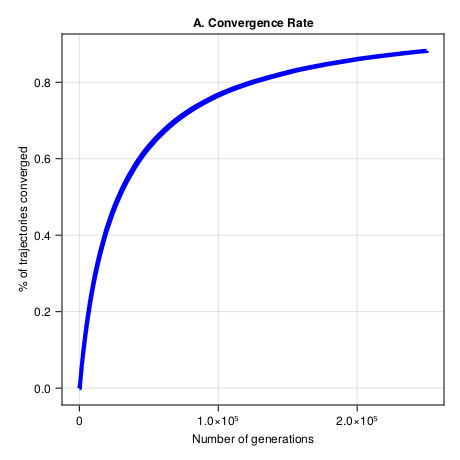

In [147]:
conv_time = map(x->sum(x),all_wait_times)

nconv = sum(all_conv)

fig = CairoMakie.Figure(resolution = (460,460), fontsize = fontsize_pub)

ax = Axis(fig[1,1])

plot_convergence_rate!(ax,conv_time,length(exp_versions)*n_trials,max_gen)

cond_save(plotsdirx(plot_save_dir_supp,"ConvergenceRate.pdf"),fig,save_fig)

fig

Assign minimal stripe topologies & evaluate basic simulation stats:

In [8]:
fs_mss =  map(list_mss->select_minimal_topologies(list_mss),all_min_fs_networks)
ls_mss =  map(list_mss->select_minimal_topologies(list_mss),all_min_end_networks);

In [9]:
countmap(map(x->length(x),all_min_end_networks))

Dict{Int64, Int64} with 6 entries:
  5 => 4
  4 => 50
  6 => 2
  2 => 3593
  3 => 300
  1 => 101898

In [10]:
nconv

105847

In [11]:
mean(map(x->size(x,2),all_geno_traj))

10.617287216453938

Build trajectory data structure:

In [12]:
trajectories = map(n->Trajectory(n,all_geno_traj[n],all_fitness_traj[n],all_wait_times[n] .+ 1,all_mut_choices[n],all_mut_types[n],all_mut_sizes[n],weight_names),1:nconv);

for (n,tr) in enumerate(trajectories)
    assign_minimal_subgraphs!(tr,fs_mss[n],ls_mss[n])
end

inc_metagraph, vertex_top_map,top_vertex_map,vertex_complexity_map,inclusion_matrix = create_inclusion_metagraph(trajectories);

minimal_motif_id = findall(indegree(inc_metagraph) .== 0);

minimal_motifs = reduce(hcat,[vertex_top_map[vertex_id] for vertex_id in minimal_motif_id])

for tr in trajectories
    assign_inc_vertex_ids!(tr,top_vertex_map)
    assign_inc_parents!(tr,inclusion_matrix,vertex_complexity_map,minimal_motif_id)
end

Evaluate/assign dependency evaluation combinatorial data:

In [14]:
# include(srcdirx("Epistasis.jl"))

# for tr in trajectories
#     evaluate_epistasis_types_full!(tr,grn_parameters,DefaultGRNSolver(),fitness_function,mutation_op)
# end

# save("epistasis_types_full_N6.jld2", "data",map(x->x.epistasis,trajectories))

In [15]:
epi_types_full = load(local_nb_data * "epistasis_types_full_N6.jld2","data")

for (tr,epi_type) in zip(trajectories,epi_types_full)
    tr.epistasis = epi_type
end

Evaluate/assign dependency evaluation classification:

In [16]:
fitness_eps = 0.01
include(srcdirx("Epistasis.jl"))

for tr in trajectories
    # cr_new = map(cr->characterise_epistasis(cr[2],fitness_eps),tr.epistasis)
    cr_new = map(cr->characterise_epistasis(cr,fitness_eps),tr.epistasis)
    tr.epistasis = cr_new
end

# Analysis 1 - MST Distribution & Dynamics

Identify MST distribution and summary stats:

In [49]:
end_parents = map(tr->tr.inc_metagraph_vertices[end],trajectories)

sorted_uep,sorted_counts_uep = return_order_by_count(end_parents);

uep_position_dict = Dict(v=>n for (n,v) in enumerate(sorted_uep));

mst_conf_int = confint(MultinomialLRT(sorted_counts_uep),0.05)

sorted_uep_other = vcat(sorted_counts_uep[1:8],[sum(sorted_counts_uep[9:end])])

mst_conf_int_r = confint(MultinomialLRT(sorted_uep_other),0.05)

top_n = 8

8

In [50]:
length(sorted_uep)

732

In [51]:
entropy(sorted_counts_uep ./ sum(sorted_counts_uep))

0.4518383207450712

In [52]:
a1 = sorted_counts_uep ./ sum(sorted_counts_uep)
mean(a1[top_n + 1:end]) * 100

0.03420578864301527

In [22]:
color_scheme = Makie.wong_colors();

Compute MST UMAP embedding:

In [23]:
embedding = umap(all_mat_av_X, 2; metric = d_metric,n_neighbors = 50,min_dist = 0.5);

Produce Figure 2 - "The distribution of adaptive outcomes relating to the core mechanisms of stripe formation"

In [32]:
#### Get example trajectories for chosen MST 

# function get_length_unique_top(tr)
#     return length(uniqueid(tr.topologies))
# end

# tr_data_temp = filter(tr->(tr.inc_metagraph_vertices[tr.H0] == sorted_uep[2]),trajectories)

# findall(tr->get_length_unique_top(tr) == 6,tr_data_temp)

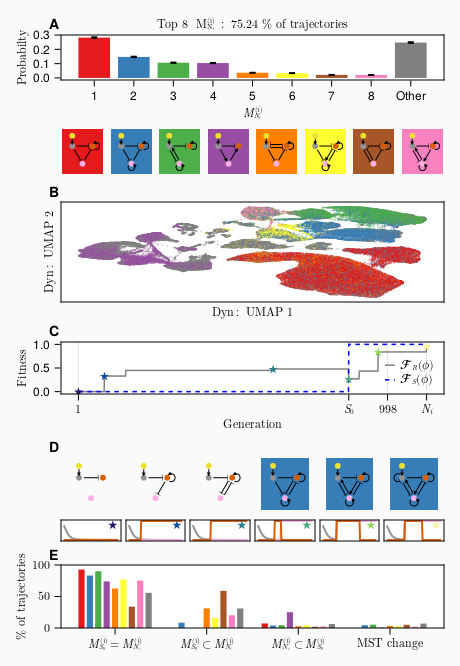

In [31]:
include(srcdirx("AnalysisVisualization.jl"))

fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (460,750-(7*12)),fontsize = fontsize_pub)

ds_config_12 = dynamical_summary_config(fontsize_pub,2.,ext_palette,node_colors,draw_config_12,1.5,12.,2.,1.,2.5,14.)

example_mst = 2

tr_choice = 2

# tr_choice = 14168
# tr_choice = 14974

min_n = length(exp_versions)*300

plot_dynamical_summary_portrait!(fig,trajectories,embedding,8,min_n,sorted_uep,sorted_counts_uep,mst_conf_int_r,end_parents,vertex_top_map,example_mst,tr_choice,ds_config_12)

cond_save(plotsdirx(plot_save_dir,"NetworkExamples.pdf"),fig,save_fig)

fig

In [126]:
pop_equal_id = map(x->x.sim_id,filter(tr->tr.minimal_stripe_subgraphs[tr.H0] == tr.minimal_stripe_subgraphs[end], trajectories))

pop_H0_incl_N_id = map(x->x.sim_id,filter(tr->Bool(test_inclusion(tr.minimal_stripe_subgraphs[end],tr.minimal_stripe_subgraphs[tr.H0])) & !(tr.minimal_stripe_subgraphs[end] == tr.minimal_stripe_subgraphs[tr.H0]),trajectories))

pop_N_incl_H0_id = map(x->x.sim_id,filter(tr->Bool(test_inclusion(tr.minimal_stripe_subgraphs[tr.H0],tr.minimal_stripe_subgraphs[end])) & !(tr.minimal_stripe_subgraphs[end] == tr.minimal_stripe_subgraphs[tr.H0]),trajectories));

pop_incl = reduce(vcat,[pop_equal_id,pop_H0_incl_N_id,pop_N_incl_H0_id]);

pop_not_incl = map(tr->tr.sim_id,filter(tr->!(tr.sim_id ∈ pop_incl),trajectories));

@assert length(pop_not_incl) + length(pop_equal_id) + length(pop_H0_incl_N_id) + length(pop_N_incl_H0_id) == length(trajectories)

length(pop_not_incl) / length(trajectories)

0.03451207875518437

# Analysis 2 - Phenotype transitions

In [33]:
development = DefaultGRNSolver()

const orig_network = trajectories[1].geno_traj[1]

founder = Individual(reshape(orig_network,(3,4)),grn_parameters,development)
orig_phenotype = founder.phenotype.u[end][3,:]

orig_phenotype = orig_phenotype ./ maximum(orig_phenotype);

In [34]:
# all_pheno = map(tr->map(g->new_phenotype(founder,reshape(g,(3,4)),development),tr.geno_traj),trajectories);
# save("all_pheno_N6.jld2", "data",all_pheno)

In [56]:
include(srcdirx("PhenotypeEvaluation.jl"))

all_pheno = load(local_nb_data * "all_pheno_N6.jld2")["data"];

# Reduce phenotype to (left_transition,right_transition,max_conc)

all_pheno_ch = map(tr_ph->map(ph->pheno_characterise(ph,lower_bound,upper_bound,min_width),tr_ph),all_pheno);

# Characterise phenotype transition. Specify how much max conc must grow by to count as distinct phenotype

growth_th = 1.01

all_pheno_mut_ch = map(tr_ph->[characterise_mutation(ph1,ph2,growth_th) for (ph1,ph2) in zip(tr_ph[1:end-1],tr_ph[2:end])],all_pheno_ch)

countmap(reduce(vcat,all_pheno_mut_ch))

Dict{Vector{Symbol}, Int64} with 21 entries:
  [:mlb_wbb, :mrb_wbb] => 251798
  [:mrb_wrb]           => 2085
  [:grow_wrb]          => 22
  [:cbb]               => 582
  [:switch_lr]         => 237
  [:grow_wlb]          => 22
  [:crb]               => 827
  [:mlb_wbb, :crb_wlb] => 98382
  [:grow_wnb]          => 1133
  [:drb]               => 35
  [:mrb_wbb]           => 136336
  [:clb_wrb]           => 14
  [:mlb_wbb]           => 27179
  [:switch_rl]         => 5
  [:clb]               => 104490
  [:clb_wrb, :mrb_wbb] => 1010
  [:mlb_wlb]           => 238925
  [:dlb]               => 17
  [:crb_wlb]           => 5859
  ⋮                    => ⋮

In [58]:
# Simplify transitions for transition graph

replace_dict = Dict([:mrb_wbb, :crb_wlb]=>[:crb_wlb],
                    [:mlb_wbb, :crb_wlb] => [:crb_wlb],
                    [:mrb_wbb] => [:mbb_wbb],
                    [:mlb_wbb] => [:mbb_wbb],
                    [:clb_wrb,:mrb_wbb]=>[:clb_wrb],
                    [:mlb_wbb, :mrb_wbb] => [:mbb_wbb],
                    [:switch_lr] => [:other_wlb],
                    [:switch_rl] => [:other_wrb],
                    [:grow_wrb] => [:other_wrb],
                    [:grow_wlb] => [:other_wlb],
                    [:grow_wbb] => [:other_wbb],
                    [:grow_wnb] => [:other_wnb],
                    [:drb]=>[:other_wrb],
                    [:dlb]=>[:other_wlb],
                    [:nothing] => [:neutral]);


all_pheno_mut_chf = map(tr_ph->map(ph->haskey(replace_dict,ph) ? replace_dict[ph] : ph,tr_ph),all_pheno_mut_ch);

countmap(reduce(vcat,all_pheno_mut_chf))

Dict{Vector{Symbol}, Int64} with 13 entries:
  [:mbb_wbb]   => 415313
  [:mrb_wrb]   => 2085
  [:other_wrb] => 62
  [:cbb]       => 582
  [:crb]       => 827
  [:clb_wrb]   => 1024
  [:other_wnb] => 1133
  [:other_wlb] => 276
  [:clb]       => 104490
  [:mlb_wlb]   => 238925
  [:crb_wlb]   => 104241
  [:neutral]   => 148886
  [:other_wbb] => 117

First boundary creation:

In [60]:
first_b = map(tr->get_first_boundary(tr),all_pheno_mut_chf);

countmap(first_b)

Dict{Int64, Int64} with 3 entries:
  2 => 807
  3 => 556
  1 => 104484

In [66]:
104484 / nconv

0.9871229227091934

First mutation ph transition:

In [55]:
fm_pheno = [mc[1] for (mc,tr) in zip(all_pheno_mut_chf,trajectories)]

countmap(fm_pheno)

Dict{Vector{Symbol}, Int64} with 5 entries:
  [:clb]       => 102834
  [:crb]       => 707
  [:cbb]       => 517
  [:other_wnb] => 1097
  [:neutral]   => 692

In [61]:
102834/104484

0.9842081084185138

In [40]:
dodge_gap = 0.03 #Makie default
gap = 0.2 #Makie default
width_1 = 1 #Makie default

xerr = compute_x([1,2,3,4], width_1, gap, [1,2,3,4], dodge_gap)

mean_wait_type_labels = compute_x([1,2,3,4], width_1, gap, [1,2,3,4], dodge_gap);

In [70]:
# % of first mutations containing new weight additively

new_additive_fm = [any(map(x->x==(true,:additive),tr.mutant_info[1].mut_type)) for tr in trajectories]

sum(new_additive_fm ) / length(trajectories)

0.9950400105813108

In [74]:
# % of these which changed w_cc

new_additive_weight_id_fm = [tr.mutant_info[1].weight_id[map(x->x==(true,:additive),tr.mutant_info[1].mut_type)] for tr in trajectories[new_additive_fm]]

sum(map(x-> 9 ∈ x,new_additive_weight_id_fm))/sum(new_additive_fm)

0.9629612046865802

In [75]:
# % of S_0 mutations havinga single weight change

S0_mut_length = countmap(map(tr->length(tr.mutant_info[tr.H0-1].weight_id), trajectories))

S0_mut_length[1] / nconv

0.03176282747739662

In [78]:
# null expectation

prob_k_mutations(1,mut_prob,10)

0.5948221475418107

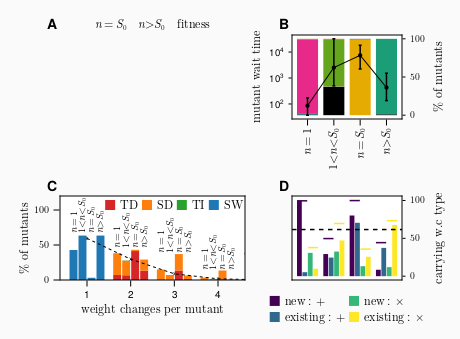

In [79]:
include(srcdirx("AnalysisVisualization.jl"))

fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (460,Int(floor(750/2)) - 3*12),fontsize = fontsize_pub)

evo_config_12 = evo_summary_config(fontsize_pub,6.,1.,ext_palette,node_colors,draw_config_12,1.,4.,2.,epi_colors,0.5)

create_epi_single_portrait_bar_v3!(fig,trajectories,mut_prob,all_pheno_mut_chf,:quantiles,evo_config_12,ds_config_12)

cond_save(plotsdirx(plot_save_dir,"ExtBarSingle_EpiSummary_v2ii.pdf"),fig,save_fig)

fig

In [86]:
morph_loop = findall(x->x ∈ ["M=>A","A=>A","C=>A","B=>A"],weight_names)
ac_loop = findall(x->x ∈ ["A=>C","C=>C"],weight_names)
abc_loop = findall(x->x ∈ ["A=>B","B=>B","B=>C","C=>B"],weight_names);

weight_loop_dict = Dict()

for i in morph_loop
    weight_loop_dict[i] = :morph_loop
end

for i in ac_loop
    weight_loop_dict[i] = :ac_loop
end

for i in abc_loop
    weight_loop_dict[i] = :abc_loop
end

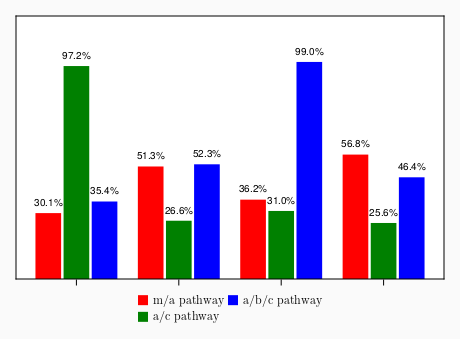

In [290]:
include(srcdirx("AnalysisVisualization.jl"))

# probability that a mutant carries at least one weight change in a pathway, split by period
fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (460,Int(floor(750/2)) - 3*12),fontsize = fontsize_pub)

identify_loop_mutations!(fig,trajectories,evo_config_12,weight_loop_dict)

cond_save(plotsdirx(plot_save_dir_supp,"LoopMutations.pdf"),fig,save_fig)

fig

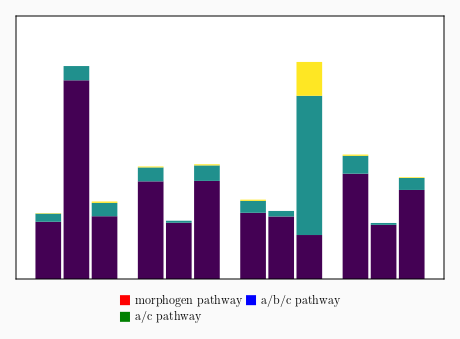

In [149]:
include(srcdirx("AnalysisVisualization.jl"))

fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (460,Int(floor(750/2)) - 3*12),fontsize = fontsize_pub)

identify_loop_mutations_nweight!(fig,trajectories,evo_config_12,weight_loop_dict)

cond_save(plotsdirx(plot_save_dir_supp,"LoopMutations_NWeight.pdf"),fig,save_fig)

fig

In [127]:
train_ttl = false
train_gtl = false

false

In [130]:
top_n

8

In [131]:
top_n = 4

predict_id = sorted_uep[1:top_n]

label_names = 1:top_n |> collect

trajectories_p = copy(trajectories)

vertex_to_predict_label = Dict(vertex=>n for (n,vertex) in enumerate(predict_id))
predict_label_to_vertex = Dict(n=>vertex for (n,vertex) in enumerate(predict_id))
predict_label_to_vertex[top_n+1] = -1
labels = map(tr->tr.inc_metagraph_vertices[tr.H0] ∈ predict_id ? vertex_to_predict_label[tr.inc_metagraph_vertices[tr.H0]] : top_n + 1,trajectories_p);

const c_types = ["c" for _ in 1:10];

const predict_colors = vcat(ext_palette[1:top_n],[:grey]);

null_H0_dist = [count(x->x==i,labels) for i in 1:top_n+1] ./ length(trajectories_p);

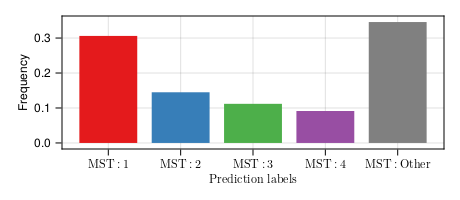

In [156]:
fig = Figure(resolution = (460,200),fontsize = fontsize_pub)

ax = Axis(fig[1,1],xlabel = L"\text{Prediction labels}", ylabel =  "Frequency")

CairoMakie.barplot!(ax,[1,2,3,4,5],null_H0_dist, color = predict_colors[1:5])

ax.xticks = (1:5,[L"\text{MST:1}",L"\text{MST:2}",L"\text{MST:3}",L"\text{MST:4}",L"\text{MST:Other}"])

cond_save(plotsdirx(plot_save_dir_supp,"NullH0Dist.pdf"),fig,save_fig)

fig

In [134]:
ac = "DN" * string(top_n)

"DN4"

In [135]:
if train_gtl || train_ttl
    train_id,test_id =  create_train_test_id_split(labels,0.8);
    save("train_test_ids_Other_" * ac * ".jld2", Dict("train" => train_id, "test" => test_id))
else
    train_id = load(local_nb_data * "train_test_ids_Other_" * ac * ".jld2", "train")
    test_id = load(local_nb_data * "train_test_ids_Other_" * ac * ".jld2", "test")
end;

In [136]:
X_train_ttl_v = [reduce(hcat,unique([vcat(features,label) for features in tr.topologies[1:tr.H0-1]])) for (label,tr) in zip(labels[train_id],trajectories_p[train_id])]
X_train_ttl = reduce(hcat,X_train_ttl_v) |> transpose |> collect

y_train_ttl = copy(Int.(X_train_ttl[:,13]))

X_train_gtl_v = [reduce(hcat,[vcat(features,label) for features in tr.geno_traj[1:tr.H0-1]]) for (label,tr) in zip(labels[train_id],trajectories_p[train_id])]
X_train_gtl  = reduce(hcat,X_train_gtl_v) |> transpose |> collect;

y_train_gtl = copy(Int.(X_train_gtl[:,13]))

###################

X_test_ttl_v = [reduce(hcat,unique([vcat(features,label) for features in tr.topologies[1:tr.H0-1]])) for (label,tr) in zip(labels[test_id],trajectories_p[test_id])]
X_test_ttl = reduce(hcat,X_test_ttl_v) |> transpose |> collect

y_test_ttl = copy(Int.(X_test_ttl[:,13]))

X_test_gtl_v = [reduce(hcat,[vcat(features,label) for features in tr.geno_traj[1:tr.H0-1]]) for (label,tr) in zip(labels[test_id],trajectories_p[test_id])]
X_test_gtl  = reduce(hcat,X_test_gtl_v) |> transpose |> collect;

y_test_gtl = copy(Int.(X_test_gtl[:,13]));

In [137]:
X_train_ttl_v_length = [reduce(hcat,[vcat(features,length(unique(tr.topologies[1:tr.H0-1]))) for features in unique(tr.topologies[1:tr.H0-1])]) for (label,tr) in zip(labels[train_id],trajectories_p[train_id])]
X_train_ttl_length  = reduce(hcat,X_train_ttl_v_length) |> transpose |> collect;

length_train_ttl = copy(Int.(X_train_ttl_length[:,13]));

X_train_gtl_v_length = [reduce(hcat,[vcat(features,tr.H0-1) for features in tr.geno_traj[1:tr.H0-1]]) for (label,tr) in zip(labels[train_id],trajectories_p[train_id])]
X_train_gtl_length  = reduce(hcat,X_train_gtl_v_length) |> transpose |> collect;

length_train_gtl = copy(Int.(X_train_gtl_length[:,13]));

In [138]:
for id in train_id
    trajectories_p[id].train_test_indicator = :train
end

for id in test_id
    trajectories_p[id].train_test_indicator = :test
end

## TTL - Train

In [139]:
if train_ttl

    params = Dict(
        "eta"=> 0.01,
        "objective"=>"multi:softprob",
        "num_class"=>top_n+1,
        "subsample"=> 0.5,
        "eval_metric"=>"auc"
    )

    max_boosting_rounds = 5000
    early_stop = 200

    d_train_ttl = xgboost.DMatrix(X_train_ttl[:,1:10], label=y_train_ttl .- 1,feature_names = weight_names)
    d_test_ttl = xgboost.DMatrix(X_test_ttl[:,1:10], label=y_test_ttl .- 1,feature_names = weight_names)

    model_ttl = xgboost.train(params, d_train_ttl, max_boosting_rounds, evals = [(d_test_ttl, "test")], verbose_eval=false, early_stopping_rounds=early_stop)

    ttl_prob_train = model_ttl.predict(d_train_ttl)
    ttl_prob_test = model_ttl.predict(d_test_ttl)

    y_pred_train_ttl = mapslices(x->argmax(x),ttl_prob_train,dims = 2)
    y_pred_test_ttl = mapslices(x->argmax(x),ttl_prob_test,dims = 2);

    print("Accuracy (test): " * string(sum(y_pred_test_ttl .== y_test_ttl) / length(y_test_ttl)))
    print("\n")

    all_bs_test = []

    for (n,p_row) in enumerate(eachrow(ttl_prob_test))
        push!(all_bs_test,brier_score(p_row,y_test_ttl[n]))
    end

    print("Brier score (test): " * string(mean(all_bs_test)))
    print("\n")

    all_bs_train = []

    for (n,p_row) in  enumerate(eachrow(ttl_prob_train))
        push!(all_bs_train,brier_score(p_row,y_train_ttl[n]))
    end

    print("Brier score (train): " * string(mean(all_bs_train)))
    print("\n")
    
    model_ttl.save_model("ModelTTL_Other_" * ac * ".json")

else
    model_ttl = xgboost.Booster()

    d_train_ttl = xgboost.DMatrix(X_train_ttl[:,1:10], label=y_train_ttl .- 1,feature_names = weight_names)
    d_test_ttl = xgboost.DMatrix(X_test_ttl[:,1:10], label=y_test_ttl .- 1,feature_names = weight_names)

    model_ttl.load_model(local_nb_data * "ModelTTL_Other_" * ac * ".json")

    ttl_prob_train = model_ttl.predict(d_train_ttl)
    ttl_prob_test = model_ttl.predict(d_test_ttl)

    y_pred_train_ttl = mapslices(x->argmax(x),ttl_prob_train,dims = 2)
    y_pred_test_ttl = mapslices(x->argmax(x),ttl_prob_test,dims = 2);
end;

## GTL - Train

In [150]:
if train_gtl

    params = Dict(
        "eta"=> 0.01,
        "objective"=>"multi:softprob",
        "num_class"=>top_n+1,
        "subsample"=> 0.5,
        "eval_metric"=>"auc"
    )

    max_boosting_rounds = 5000
    early_stop = 200

    d_train_gtl = xgboost.DMatrix(X_train_gtl[:,1:10], label=y_train_gtl .- 1,feature_names = weight_names)
    d_test_gtl = xgboost.DMatrix(X_test_gtl[:,1:10], label=y_test_gtl .- 1,feature_names = weight_names)

    model_gtl = xgboost.train(params, d_train_gtl, max_boosting_rounds, evals = [(d_test_gtl, "test")], verbose_eval=false, early_stopping_rounds=early_stop)

    gtl_prob_train = model_gtl.predict(d_train_gtl)
    gtl_prob_test = model_gtl.predict(d_test_gtl)

    y_pred_train_gtl = mapslices(x->argmax(x),gtl_prob_train,dims = 2)
    y_pred_test_gtl = mapslices(x->argmax(x),gtl_prob_test,dims = 2);

    print("Accuracy (test): " * string(sum(y_pred_test_gtl .== y_test_gtl) / length(y_test_gtl)))
    print("\n")

    all_bs_test = []

    for (n,p_row) in  enumerate(eachrow(gtl_prob_test))
        push!(all_bs_test,brier_score(p_row,y_test_gtl[n]))
    end

    print("Brier score (test): " * string(mean(all_bs_test)))
    print("\n")

    all_bs_train = []

    for (n,p_row) in  enumerate(eachrow(gtl_prob_train))
        push!(all_bs_train,brier_score(p_row,y_train_gtl[n]))
    end

    print("Brier score (train): " * string(mean(all_bs_train)))
    print("\n")

    model_gtl.save_model("ModelGTL_Other_" * ac * ".json")

else
    model_gtl = xgboost.Booster()

    d_train_gtl = xgboost.DMatrix(X_train_gtl[:,1:10], label=y_train_gtl .- 1,feature_names = weight_names)
    d_test_gtl = xgboost.DMatrix(X_test_gtl[:,1:10], label=y_test_gtl .- 1,feature_names = weight_names)

    model_gtl.load_model(local_nb_data * "ModelGTL_Other_" * ac * ".json")

    gtl_prob_train = model_gtl.predict(d_train_gtl)
    gtl_prob_test = model_gtl.predict(d_test_gtl)

    y_pred_train_gtl = mapslices(x->argmax(x),gtl_prob_train,dims = 2)
    y_pred_test_gtl = mapslices(x->argmax(x),gtl_prob_test,dims = 2);

end;

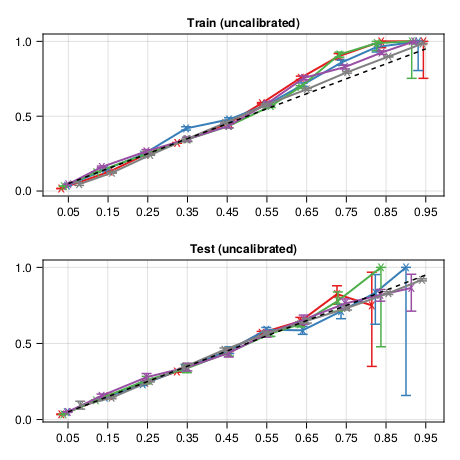

In [155]:
fig = Figure(resolution = (460,460),fontsize = fontsize_pub)

produce_prob_calibration_curve_binomial!(fig,y_train_gtl,gtl_prob_train,y_test_gtl,gtl_prob_test,predict_colors)

cond_save(plotsdirx(plot_save_dir_supp,"GTL_ProbabilityCalibration.pdf"),fig,save_fig)

fig

In [158]:
include(srcdirx("TrajectoryAnalysis.jl"))

for tr in trajectories_p
    assign_predictions!(tr,model_ttl,:tt,predict_label_to_vertex)
    assign_predictions!(tr,model_gtl,:gt,predict_label_to_vertex)
end

for (tr,label) in zip(trajectories_p,labels)
    assign_tt_other_prediction_errors!(tr,predict_label_to_vertex[label],predict_id)
    assign_gt_other_prediction_errors!(tr,predict_label_to_vertex[label],predict_id)
end

for tr in trajectories_p
    assign_weight_edits!(tr)
end

for tr in trajectories_p
    kl_div = [i == 1 ? StatsBase.kldivergence(tr.gt_label_probabilities[1,:],tr.gt_label_probabilities[i,:] .+ eps(),size(tr.gt_label_probabilities,2)) :  StatsBase.kldivergence(tr.gt_label_probabilities[i-1,:],tr.gt_label_probabilities[i,:] .+ eps(),size(tr.gt_label_probabilities,2)) for i in 1:size(tr.gt_label_probabilities,1)]
    tr.gt_kl_div = kl_div
end

In [98]:
# include(srcdirx("TrajectoryAnalysis.jl"))

# for tr in trajectories_p
#     assign_shap!(tr,model_gtl,:gt)
# end

# save("shap_contributions_N6.jld2", "data",map(x->x.other,trajectories_p))

In [210]:
shap_cont = load(local_nb_data * "shap_contributions_N6.jld2")["data"];

for (tr,shap_values) in zip(trajectories_p,shap_cont)
    tr.other = shap_values
end

In [267]:
ph_id = findall(tr->tr.H0 > 2,trajectories_p); # dont include any trajectories which acieved stripe on first mutation

# all_epi = reduce(vcat,[tr.epistasis[1:tr.H0-2] for tr in trajectories_p[ph_id]])
# all_shap = reduce(vcat,[[tr.other[n+1,:,tr.mutant_info[n].weight_id] for n in 1:tr.H0-2] for tr in trajectories_p[ph_id]])

all_epi = reduce(vcat,[tr.epistasis[1] for tr in trajectories_p[ph_id]])
all_shap = reduce(vcat,[[tr.other[2,:,tr.mutant_info[1].weight_id]] for tr in trajectories_p[ph_id]])

# each entry of all_shap is a matrix n_pred_class x n_weight representing the shap explanation for the mutant
# all_epi contains the dependency evaluation for each mutant

@assert length(all_epi) == length(all_shap)

se_2mut_id = findall(x->(x[1] == :se) & (length(x[2]) == 4), all_epi);
rse_2mut_id = findall(x->(x[1] == :rse) & (length(x[2]) == 4), all_epi);

function compute_weight_importance(shap_mat)
    return sum(abs.(shap_mat),dims = 1)
end

shap_m_se = reduce(vcat,map(x->compute_weight_importance(x),all_shap[se_2mut_id])) |> transpose |> collect
shap_m_rse = reduce(vcat,map(x->compute_weight_importance(x),all_shap[rse_2mut_id])) |> transpose |> collect;

In [268]:
# epi_c_rse = [all(epi_m_rse[:,n] .== maximum(epi_m[:,n])) ? [true,false] : epi_m_rse[:,n] .== maximum(epi_m_rse[:,n]) for n  in 1:size(epi_m_rse,2)];

# epi_c_rse = reduce(hcat,epi_c_rse)

# get DE contributions for each weight for each 2-weight mutant

epi_m_rse = reduce(hcat,map(x->x[2][2:3],all_epi[rse_2mut_id])) 
epi_m_se = reduce(hcat,map(x->x[2][2:3],all_epi[se_2mut_id])) 

# identify which is carrier (within epsilon of original fitness) versus hitchhiker 

epi_c_se = epi_m_se .> 1 - fitness_eps

@assert all(x->x==1,sum(epi_c_se,dims = 1))

# identify those SD which are deleterious rather than just neutral

deleterious = [epi_m_se[.!epi_c_se[:,n],n][1] < 0 for n in 1:size(epi_m_se,2)];

# compute ration of shapley importance between carrier and hitchhiker

epi_ratio_se = reduce(vcat,[shap_m_se[epi_c_se[:,n],n] ./ shap_m_se[.!epi_c_se[:,n],n] for n in 1:size(epi_c_se,2)]);

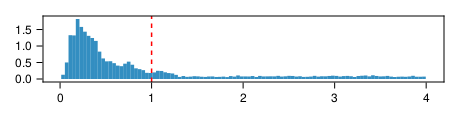

In [269]:
fig = CairoMakie.Figure(resolution = (460,120),fontsize = 12.)
ax1 = Axis(fig[1,1], xgridvisible = false,ygridvisible = false)

# CairoMakie.hist!(ax, filter(x->x < 4,epi_ratio[.!deleterious]), offset=0, direction=:y, bins = 100)
CairoMakie.hist!(ax1, filter(x->x < 4,epi_ratio_se[deleterious]), bins = 100,normalization = :pdf)

CairoMakie.vlines!(ax1,1., color = :red, linestyle = :dash)

# ax1.yticks = (0:0,[L"\text{S.E}"])
# ax2.yticks = (0:0,[L"\text{R.S.E}"])

fig

In [283]:
include(srcdirx("PredictionAnalytics.jl"))

test_traj = findall(tr->tr.train_test_indicator == :test,trajectories_p);
label_streak = labels[test_traj];

streak_tt= [find_streak_tt(tr,:tedit) for (tr,l) in zip(trajectories_p[test_traj],labels[test_traj])];
streak_gt= [find_streak_gt(tr,:tedit) for (tr,l) in zip(trajectories_p[test_traj],labels[test_traj])];

for i in 1:5
    print(1 - sum(streak_gt[label_streak .==i] .== 1)/length(streak_gt[label_streak .==i]))
    print("\n")
end

print(1 - sum(streak_gt .== 1)/length(streak_gt))

0.6910493827160493
0.6121251629726205
0.7108484592655129
0.5873836608066184
0.6993169398907104
0.6752160974918521

In [285]:
1 - sum(streak_tt .== 1)/length(streak_tt)

0.4817911293750886

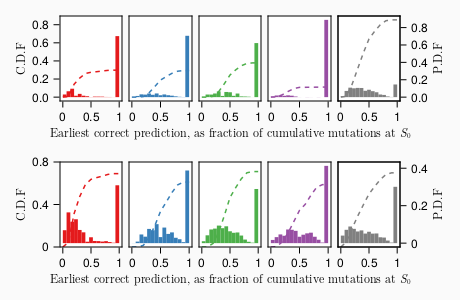

In [291]:
include(srcdirx("AnalysisVisualization.jl"))

fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (460,300),fontsize = fontsize_pub)

fig_n1 = fig[1,1] = GridLayout()
fig_n2 = fig[2,1] = GridLayout()

create_pred_accuracy_fig_nn!(fig_n1,streak_tt,label_streak,predict_colors,top_n)
create_pred_accuracy_fig!(fig_n2,streak_gt,label_streak,predict_colors,top_n)

cond_save(plotsdirx(plot_save_dir_supp,"ModelPredictability_TTvsGT.pdf"),fig,save_fig)

fig

In [292]:
contingency_data = Dict()

Dict{Any, Any}()

In [293]:
mut_n = 1
n_weight = 2

fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
resolution = (1600, 1300),fontsize = 18.)

all_target_mutants = []
all_target_networks = []
all_target_prob = []
all_target_ent_deltas = []
all_target_max_ent = []

for n in 1:top_n+1

    if n == 1
        ax_geno = Axis(fig[n,1],backgroundcolor = (predict_colors[n],1.), title = L"\text{Prediction after \text{mut}^{(i)}_{1}}",aspect = DataAspect())

        ax_h = Axis(fig[n,2], title = L"\text{Entropy reductions}", xlabel = L"\Delta H(\text{mut}^{(i)}_{1})")
        ax_s = Axis(fig[n,3], title = L"\text{Conditional entropy reductions}", xlabel = L"\text{mutant weight edits}",ylabel = L"\Delta H(\text{mut}^{(i)}_{1})")

        ax_geno_m = Axis(fig[n,4], title = L"\text{V.I.M}",aspect = DataAspect())
    else
        ax_geno = Axis(fig[n,1],backgroundcolor = (predict_colors[n],1.),aspect = DataAspect())

        ax_h = Axis(fig[n,2], xlabel = L"\Delta H(\text{mut}^{(i)}_{1})")
        ax_s = Axis(fig[n,3], xlabel = L"\text{mutant weight edits}",ylabel = L"\Delta H(\text{mut}^{(i)}_{1})")

        ax_geno_m = Axis(fig[n,4],aspect = DataAspect())
    end

    if n == top_n+1
        sample = filter(tr->tr.gt_label_predictions[mut_n+1] == -1 ,trajectories_p)
    else
        sample = filter(tr->tr.gt_label_predictions[mut_n+1] == sorted_uep[n],trajectories_p)
    end

    # sample = filter(tr->(tr.gt_label_predictions[mut_n+1] ∈ sorted_uep[n]) & (tr.train_test_indicator == :test) ,trajectories_p)

    sample_entropy_deltas = map(tr->tr.gt_label_entropies[2:end] .- tr.gt_label_entropies[1:end-1],sample);
    sample_top_edits_deltas = map(tr->tr.weight_edits[2:end] .- tr.weight_edits[1:end-1],sample)

    sample_start_networks = map(tr->tr.geno_traj[mut_n],sample)
    sample_resultant_networks = map(tr->tr.geno_traj[mut_n+1],sample)

    sample_mutations = map(tr->tr.mutant_info[mut_n],sample)

    sample_probabilities = map(tr->tr.gt_label_probabilities[mut_n+1,:],sample)

    sample_top_edits_delta_select = map(x->x[mut_n],sample_top_edits_deltas);

    sample_entropy_delta_select = map(x->x[mut_n],sample_entropy_deltas);

    max_ent_delta = minimum(sample_entropy_delta_select[findall(sample_top_edits_delta_select .== n_weight)])

    target_mutant_id = findall(sample_top_edits_delta_select .== n_weight) ∩ findall(sample_entropy_delta_select .== max_ent_delta)

    target_mutant = sample_mutations[target_mutant_id[1]]

    target_prob = sample_probabilities[target_mutant_id[1]]

    push!(all_target_mutants,target_mutant)
    push!(all_target_prob,target_prob)
    push!(all_target_max_ent,max_ent_delta)
    push!(all_target_ent_deltas,sample_entropy_delta_select[findall(sample_top_edits_delta_select .== n_weight)])

    start_network = sample_start_networks[target_mutant_id[1]]
    resultant_network = sample_resultant_networks[target_mutant_id[1]]

    push!(all_target_networks,(start_network,resultant_network))

    CairoMakie.hist!(ax_h,sample_entropy_delta_select ,bins = 50, normalization = :pdf)

    CairoMakie.scatter!(ax_s,sample_top_edits_delta_select,sample_entropy_delta_select ,markersize =  [i == target_mutant_id[1] ? 10. : 6. for i in 1:length(sample_entropy_delta_select)], color = [i == target_mutant_id[1] ? :red : (:grey,0.5) for i in 1:length(sample_entropy_delta_select)])

    if n != top_n+1
        draw_grn!(ax_geno,vertex_top_map[sorted_uep[n]],draw_config_18,node_colors,18,false,false)
    else
        hidedecorations!(ax_geno)
    end

    draw_grn_mutant!(ax_geno_m,start_network,resultant_network,draw_config_18,fs18_default,node_colors,18.,predict_colors[n],false,false)

    hideydecorations!(ax_h)

end

# fig

In [294]:
# [0.0 0.0 0.0 1.2490335893436255; -1.7574707655694604 0.0 0.0 0.0; -0.21577059555519695 0.0 0.8867674599052598 0.0]
# [0.0 0.0 0.0 1.2490335893436255; 0.0 1.987034531358056 0.0 0.0; -0.21577059555519695 0.0 2.3162108144754048 0.0]
# [0.0 2.2881326859196505 0.0 1.2490335893436255; 0.0 0.0 0.0 0.0; -0.21577059555519695 0.0 1.8680307702243464 0.0]
# [0.0 0.0 0.0 1.2490335893436255; 2.382718773230891 0.0 0.0 0.0; -0.21577059555519695 1.5666679082774881 0.0 0.0]
# [0.0 0.0 0.0 1.2490335893436255; 0.0 0.0 2.5103478391869314 0.0; -0.21577059555519695 0.0 2.3492786163379145 0.0]

test_networks = map(x->reshape(x[2],(3,4)), all_target_networks)

5-element Vector{Matrix{Float64}}:
 [0.0 0.0 0.0 1.2490335893436255; -1.7574707655694604 0.0 0.0 0.0; -0.21577059555519695 0.0 0.8867674599052598 0.0]
 [0.0 0.0 0.0 1.2490335893436255; 0.0 1.987034531358056 0.0 0.0; -0.21577059555519695 0.0 2.3162108144754048 0.0]
 [0.0 2.2881326859196505 0.0 1.2490335893436255; 0.0 0.0 0.0 0.0; -0.21577059555519695 0.0 1.8680307702243464 0.0]
 [0.0 0.0 0.0 1.2490335893436255; 2.382718773230891 0.0 0.0 0.0; -0.21577059555519695 1.5666679082774881 0.0 0.0]
 [0.0 0.0 0.0 1.2490335893436255; 0.0 0.0 2.5103478391869314 0.0; -0.21577059555519695 0.0 2.3492786163379145 0.0]

In [295]:
test_networks_top = map(x->Int.(sign.(x)), test_networks)

5-element Vector{Matrix{Int64}}:
 [0 0 0 1; -1 0 0 0; -1 0 1 0]
 [0 0 0 1; 0 1 0 0; -1 0 1 0]
 [0 1 0 1; 0 0 0 0; -1 0 1 0]
 [0 0 0 1; 1 0 0 0; -1 1 0 0]
 [0 0 0 1; 0 0 1 0; -1 0 1 0]

In [296]:
predict_mst = [vertex_top_map[id] for id in predict_id];
predict_mst_complexity = [sum(abs.(v)) for v in predict_mst];

In [297]:
all_top_msn = []

all_top_msn_counts = []

vim_trajectories = []
vim_vertex_top_map = []

for n in 1:top_n+1

    data_con = load(datadirx("exp_pro/DeNovoStripe/Contingencies/RE_Minimal_Inhibiting_DN_Contingent_" * string(n) * "_RawData.jld2"));

    conv_con = copy(data_con["converged"]);

    print("MST: " * string(n) * " - " * string(sum(conv_con)/length(conv_con)))
    print("\n")
    
    nconv_con = sum(conv_con)

    fs_mss_con =  map(list_mss->select_minimal_topologies(list_mss),data_con["min_fs_networks"])
    ls_mss_con =  map(list_mss->select_minimal_topologies(list_mss),data_con["min_end_networks"]);

    trajectories_con = map(k->Trajectory(k,data_con["geno_traj"][conv_con][k],data_con["fitness_traj"][conv_con][k],data_con["wait_times"][conv_con][k] .+ 1,data_con["mut_choices"][conv_con][k],data_con["mut_type"][conv_con][k],data_con["mut_sizes"][conv_con][k],weight_names),1:nconv_con);

    for (nt,tr) in enumerate(trajectories_con)
        assign_minimal_subgraphs!(tr,fs_mss_con[nt],ls_mss_con[nt])
    end

    inc_metagraph_con, vertex_top_map_con,top_vertex_map_con,vertex_complexity_map_con,inclusion_matrix_con = create_inclusion_metagraph(trajectories_con);

    minimal_motif_id_con = findall(indegree(inc_metagraph_con) .== 0);

    minimal_motifs_con = reduce(hcat,[vertex_top_map_con[vertex_id] for vertex_id in minimal_motif_id_con]);

    for tr in trajectories_con
        tr.inc_metagraph_vertices = create_label_H0(tr,top_vertex_map,predict_id,predict_mst)
        tr.inc_metagraph_parents = create_label_H0_parent(tr,top_vertex_map,predict_id,predict_mst,predict_mst_complexity)
    end

    push!(vim_trajectories,trajectories_con)
    push!(vim_vertex_top_map,vertex_top_map_con)

end

contingency_data["Double"] = [all_target_networks,all_target_prob,vim_trajectories,all_target_ent_deltas,all_target_max_ent,all_target_mutants];

MST: 1 - 1.0


MST: 2 - 0.964


MST: 3 - 0.6882


MST: 4 - 0.9856


MST: 5 - 0.732


In [298]:
all_top_msn = []

all_top_msn_counts = []

vim_trajectories = []
vim_vertex_top_map = []

for n in 1:top_n+1

    data_con = load(datadirx("exp_pro/DeNovoStripe/Contingencies/RE_Minimal_Inhibiting_DN_ContingentOS_" * string(n) * "_RawData.jld2"));

    conv_con = copy(data_con["converged"]);

    print("MST: " * string(n) * " - " * string(sum(conv_con)/length(conv_con)))
    print("\n")
    
    nconv_con = sum(conv_con)

    fs_mss_con =  map(list_mss->select_minimal_topologies(list_mss),data_con["min_fs_networks"])
    ls_mss_con =  map(list_mss->select_minimal_topologies(list_mss),data_con["min_end_networks"]);

    trajectories_con = map(k->Trajectory(k,data_con["geno_traj"][conv_con][k],data_con["fitness_traj"][conv_con][k],data_con["wait_times"][conv_con][k] .+ 1,data_con["mut_choices"][conv_con][k],data_con["mut_type"][conv_con][k],data_con["mut_sizes"][conv_con][k],weight_names),1:nconv_con);

    for (nt,tr) in enumerate(trajectories_con)
        assign_minimal_subgraphs!(tr,fs_mss_con[nt],ls_mss_con[nt])
    end

    inc_metagraph_con, vertex_top_map_con,top_vertex_map_con,vertex_complexity_map_con,inclusion_matrix_con = create_inclusion_metagraph(trajectories_con);

    minimal_motif_id_con = findall(indegree(inc_metagraph_con) .== 0);

    minimal_motifs_con = reduce(hcat,[vertex_top_map_con[vertex_id] for vertex_id in minimal_motif_id_con]);

    for tr in trajectories_con
        tr.inc_metagraph_vertices = create_label_H0(tr,top_vertex_map,predict_id,predict_mst)
        tr.inc_metagraph_parents = create_label_H0_parent(tr,top_vertex_map,predict_id,predict_mst,predict_mst_complexity)
    end

    push!(vim_trajectories,trajectories_con)
    push!(vim_vertex_top_map,vertex_top_map_con)

end

contingency_data["Single"] = [vim_trajectories];

MST: 1 - 0.9932


MST: 2 - 0.9128


MST: 3 - 0.9356


MST: 4 - 0.979


MST: 5 - 0.7042


In [299]:
founder_fitness = fitness_function(founder.phenotype)

(-1.0, 0.001483405426542828)

In [300]:
test_indices = Tuple.(findall(x->x>0,viable_mutations));

N_sample = 100

sample_points = LinRange(-max_w, max_w, N_sample);

In [119]:
# fitness_grid,pred_grid,entropy_grid,prob_grid = create_pairwise_fitness_landscape(founder,development,model_gtl,test_indices,N_sample,sample_points)

# save("grid_data_" * ac * ".jld2", Dict("fitness" => fitness_grid, "pred"=>pred_grid,"prob"=>prob_grid,"entropy"=>entropy_grid))

In [302]:
fitness_grid = load(local_nb_data * "grid_data_" * ac * ".jld2","fitness")
pred_grid  = load(local_nb_data *  "grid_data_" * ac * ".jld2","pred")
entropy_grid  = load(local_nb_data * "grid_data_" * ac * ".jld2","entropy")
prob_grid = load(local_nb_data *  "grid_data_" * ac * ".jld2","prob");

In [304]:
include(srcdirx("AnalysisVisualization.jl"))
include(srcdirx("PredictionFitnessLandscapes.jl"))

contin_target = [4,3,1,2,5]

test_indices = Tuple.(findall(x->x>0,viable_mutations));

min_prob = 1e-4

contin_choices,contin_prob = find_candidates(founder,all_target_networks,contin_target,top_n,model_gtl,test_indices,pred_grid,prob_grid,fitness_grid,sample_points,min_prob);

In [305]:
[a for a in contin_choices]

5-element Vector{Matrix{Float64}}:
 [0.0 0.0 0.0 1.2490335893436255; 1.5151515151515156 0.0 0.0 0.0; -0.21577059555519695 0.0 0.9090909090909083 0.0]
 [0.0 0.0 0.0 1.2490335893436255; 0.0 3.5353535353535364 0.0 0.0; -0.21577059555519695 0.0 0.7070707070707076 0.0]
 [0.0 -0.10101010101010033 0.0 1.2490335893436255; 0.0 0.0 0.0 0.0; -0.21577059555519695 0.0 0.9090909090909083 0.0]
 [0.0 0.0 0.0 1.2490335893436255; -1.5151515151515147 0.0 0.0 0.0; -0.21577059555519695 -0.10101010101010033 0.0 0.0]
 [0.0 0.0 0.0 1.2490335893436255; 0.0 0.0 2.525252525252526 0.0; -0.21577059555519695 0.0 2.7272727272727266 0.0]

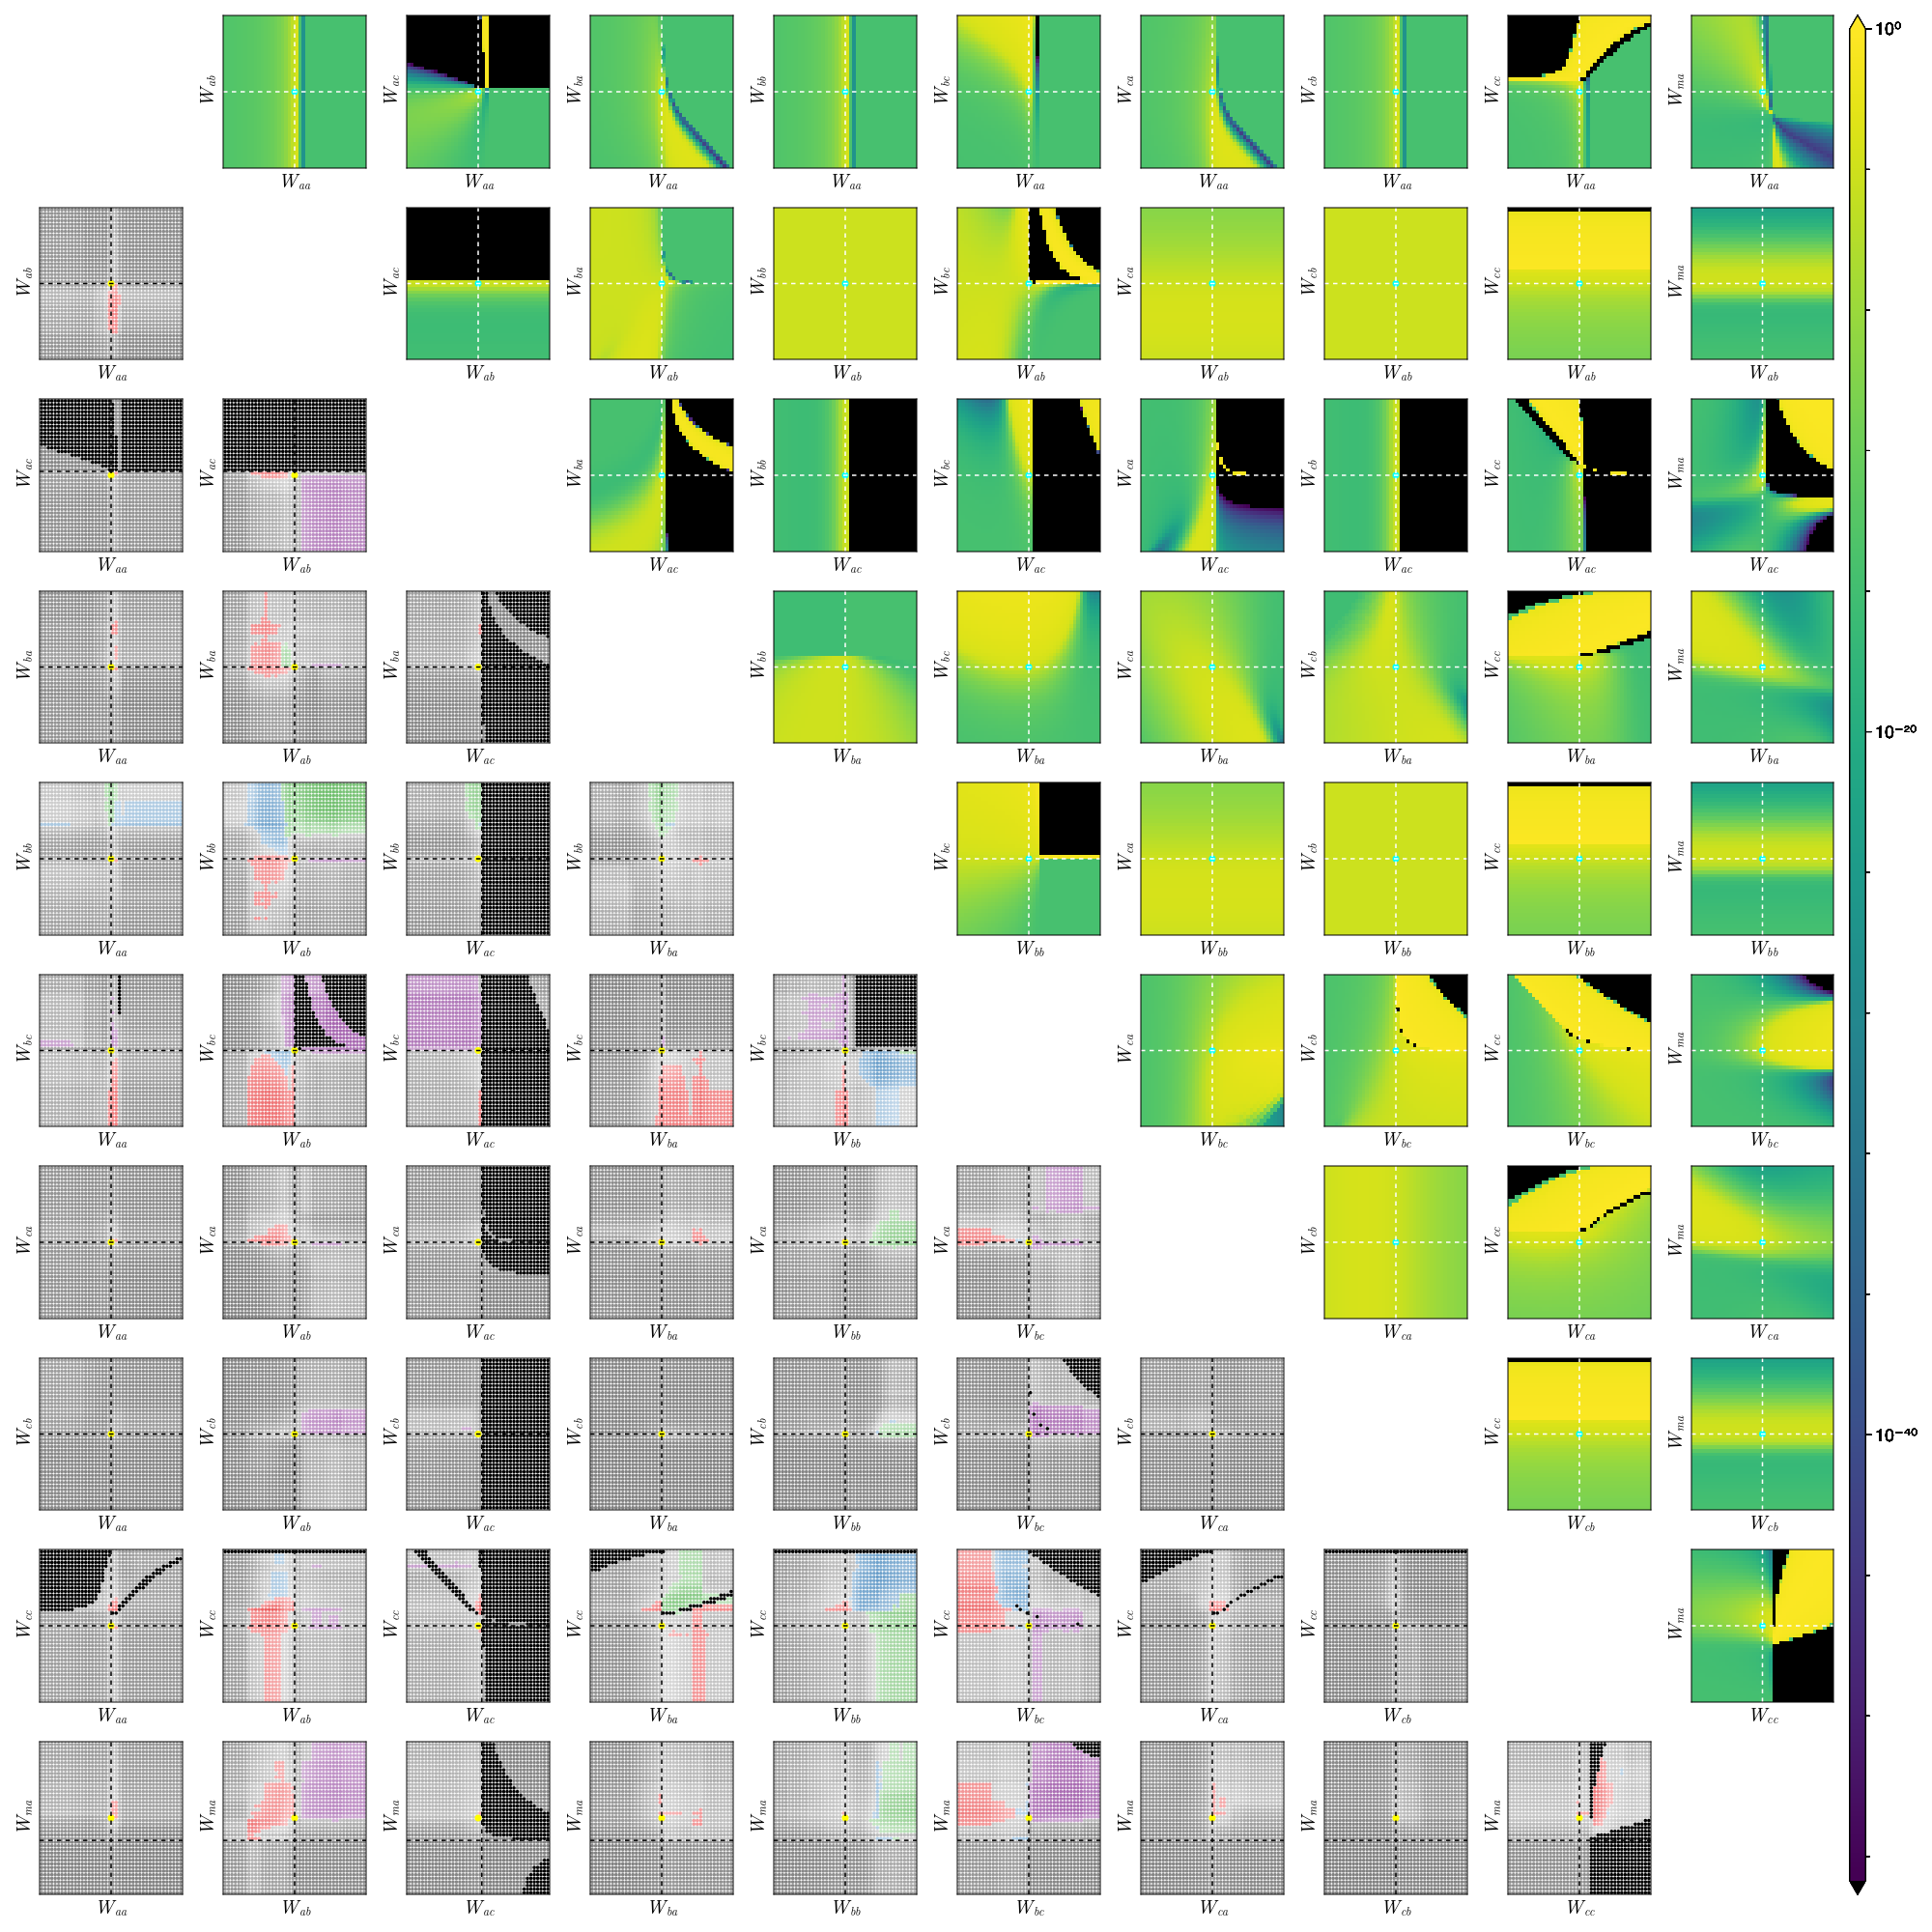

In [307]:
include(srcdirx("PredictionFitnessLandscapes.jl"))

fig = CairoMakie.Figure(resolution = (2000,2000),fontsize = 20)

start_network = [0.0 0.0 0.0 1.2490335893436255; 0.0 0.0 0.0 0.0; -0.21577059555519695 0.0 0.0 0.0]

mut_q = 0.99999

plot_pairwise_fitness_landscape!(fig,test_indices,sample_points,founder,mut_q,mutation_op,fitness_grid,pred_grid,prob_grid,predict_colors)

cond_save(plotsdirx(plot_save_dir_supp,"PairwiseFS_AllFitness.pdf"),fig,true)

fig

In [308]:
# ex_s0_tr = trajectories_p[3]

# ex_s0_network = reshape(ex_s0_tr.geno_traj[ex_s0_tr.H0-1],(3,4))

# founder_s0 = Individual(reshape(ex_s0_network,(3,4)),grn_parameters,development);

# fitness_grid_S0, stripe_ind_S0,mst_grid_S0 = create_pairwise_mst_fitness_landscape(founder_s0,development,test_indices,N_sample,sample_points)

# # save("s0_grid_data.jld2", Dict("fitness" => fitness_grid_S0, "stripe"=>stripe_ind_S0,"mst"=>mst_grid_S0))

# fitness_grid_s0 = load(local_nb_data * "s0_grid_data.jld2","fitness")
# stripe_ind_s0 = load(local_nb_data * "s0_grid_data.jld2","stripe")
# mst_grid_s0  = load(local_nb_data * "s0_grid_data.jld2","mst");

# mst_label_grid_s0 = fill(0.,(10,10,N_sample*N_sample))

# for (n1,t1) in enumerate(test_indices)
#     for (n2,t2) in enumerate(test_indices)
#         if n1 < n2
#             mst_label_grid_s0[n1,n2,:] = mapslices(v->assign_mst_label(v,top_vertex_map,predict_id,vertex_to_predict_label),mst_grid_s0[n1,n2,:,:],dims = 2)
#         end
#     end
# end

# fig = CairoMakie.Figure(resolution = (2000,2000),fontsize = 20)

# plot_mst_fitness_landscape!(fig,test_indices,sample_points,founder,mut_q,mutation_op,fitness_grid_s0 ,stripe_ind_s0 ,mst_grid_s0 ,mst_label_grid_s0,predict_colors)

# cond_save(plotsdirx(plot_save_dir,"S0_PairwiseFS_AllFitness.pdf"),fig,true)

# fig


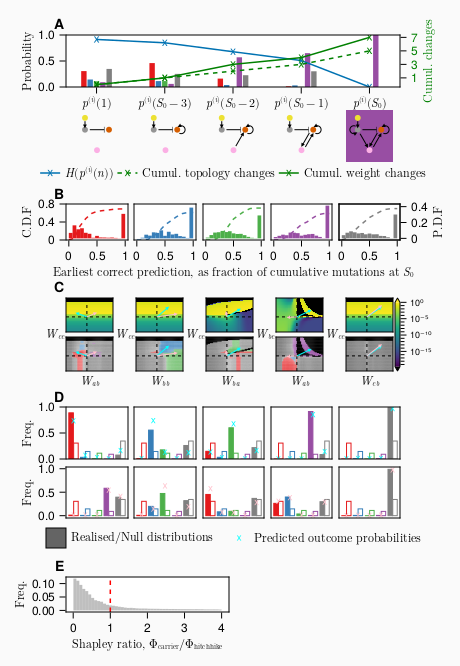

In [311]:
include(srcdirx("AnalysisVisualization.jl"))

fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (460,750-7*12),fontsize = fontsize_pub)

contin_target = [4,3,1,2,5]

mut_q = 0.99999

create_full_prediction_summary_epi!(fig,trajectories_p,sorted_uep,top_n,contingency_data,contin_choices,predict_label_to_vertex,vertex_to_predict_label,mut_q,fitness_eps,sample_points,predict_colors,fs12_default,evo_config_12,ds_config_12,fontsize_pub)

cond_save(plotsdirx(plot_save_dir,"Fig4_prediction2.pdf"),fig,true)

# should add error bars to realised distributions
# for realised based on first mut and then prediction - we should be able to make prediction based on how beta changes to Inf. 
# probability weighted entropy of first mutation as a measure of systems constraint at first mutation 

fig

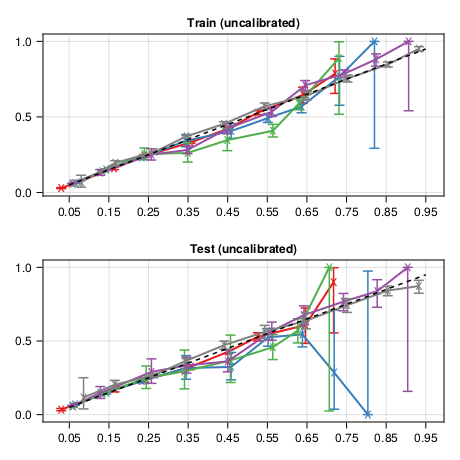

In [313]:
first_pred_prob_test = reduce(hcat,map(tr->tr.gt_label_probabilities[2,:],trajectories_p[test_id])) |> transpose |> collect
first_pred_prob_train = reduce(hcat,map(tr->tr.gt_label_probabilities[2,:],trajectories_p[train_id])) |> transpose |> collect;

first_pred_prob_all = reduce(hcat,map(tr->tr.gt_label_probabilities[2,:],trajectories_p)) |> transpose |> collect;

fig = Figure(resolution = (460,460),fontsize = fontsize_pub)

produce_prob_calibration_curve_binomial!(fig,labels[train_id],first_pred_prob_train,labels[test_id],first_pred_prob_test,predict_colors)

cond_save(plotsdirx(plot_save_dir_supp,"PDCalibrationMutatioonn=1.pdf"),fig,true)

fig

In [ ]:
# fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
#     resolution = (460,110),fontsize = fontsize_pub)

# fig_hist = fig[1,1] = GridLayout()
# fig_pie = fig[1,2] = GridLayout()

# ax = Axis(fig_hist[1,1])

# traj_epi_pop = filter(tr->(length(tr.mutant_info[1].weight_id) == 3) & (tr.gt_label_predictions[2] .!= -1),trajectories_p)

# all_first_entropies = map(tr->tr.gt_label_entropies[2],traj_epi_pop)

# all_first_pred = [tr.gt_label_predictions[2] == -1 ? 5 : vertex_to_predict_label[tr.gt_label_predictions[2]] for tr in traj_epi_pop]

# first_epi = map(tr->tr.epistasis[2],traj_epi_pop)

# CairoMakie.hist!(ax,all_first_entropies,bins = 50,color = (:grey,0.5))

# bin_boundaries = [0.6,0.65,0.7]

# CairoMakie.vlines!(bin_boundaries,linestyle = :dash, color = :black)

# # h_first_ent = fit(Histogram, all_first_entropies, bin_boundaries; closed = :left) 

# h_first_ent = fit(Histogram, all_first_entropies, bin_boundaries; closed = :left) 

# first_ent_bins = map(f->StatsBase.binindex(h_first_ent, f),all_first_entropies);

# for i in 0:length(bin_boundaries)

#     ax_pred = Axis(fig_pie[1,i+1]) 
#     # ax_epi = Axis(fig_pie[2,i+1]) 

#     pred_prop = calculate_pred_proportion(all_first_pred[first_ent_bins .== i])

#     CairoMakie.pie!(ax_pred,pred_prop,radius = evo_config_12.pie_radius,color = predict_colors,
#     inner_radius = evo_config_12.pie_inner_radius,
#     strokecolor = :white,
#     strokewidth = evo_config_12.pie_strokewidth)

#     # CairoMakie.pie!(ax_epi,epi_prop,radius = evo_config_12.pie_radius,color = evo_config_12.pie_colors,
#     # inner_radius = evo_config_12.pie_inner_radius,
#     # strokecolor = :white,
#     # strokewidth = evo_config_12.pie_strokewidth)

#     CairoMakie.hidedecorations!(ax_pred)
#     # CairoMakie.hidedecorations!(ax_epi)
# end

# rowgap!(fig_hist, Relative(0.02))
# colgap!(fig_hist, Relative(0.02))

# rowgap!(fig_pie, Relative(0.02))
# colgap!(fig_pie, Relative(0.02))

# rowgap!(fig.layout, Relative(0.02))
# colgap!(fig.layout, Relative(0.02))

# fig

In [ ]:
h_first_ent = fit(Histogram, all_first_entropies, bin_boundaries; closed = :left) 

first_ent_bins = map(f->StatsBase.binindex(h_first_ent, f),all_first_entropies);

function calculate_pred_proportion(preds)
    
    total = length(preds)

    return [count(x->x==p,preds)/total for p in [1,2,3,4,5]]
end

In [ ]:
calculate_pred_proportion(all_first_pred[first_ent_bins .== 2])

In [ ]:
countmap(first_epi[first_ent_bins .== 1])

In [ ]:
countmap(first_epi[first_ent_bins .== 2])

In [ ]:
# [0.0 0.0 0.0 1.2490335893436255; 3.333333333333332 0.0 0.0 0.0; -0.21577059555519695 0.0 -0.9090909090909092 0.0]
# [0.0 0.0 0.0 1.2490335893436255; 0.0 3.737373737373737 0.0 0.0; -0.21577059555519695 0.0 0.9090909090909083 0.0]
# [0.0 -0.30303030303030276 0.0 1.2490335893436255; 0.0 0.0 0.0 0.0; -0.21577059555519695 0.0 0.9090909090909083 0.0]
# [0.0 0.0 0.0 1.2490335893436255; -0.7070707070707076 0.0 0.0 0.0; -0.21577059555519695 -0.10101010101010033 0.0 0.0]
# [0.0 0.0 0.0 1.2490335893436255; 0.0 0.0 2.929292929292931 0.0; -0.21577059555519695 0.0 2.525252525252526 0.0]

contin_choices

In [ ]:
contin_prob[end]

In [ ]:
vim_trajectories = contingency_data["Single"][1]

vim_trajectories[2][2].geno_traj

In [ ]:
# associate incorrect predictions with "rarer trajectories" consisting of non-typical mutations
# explain final distribution of outcomes by monte carlo on initial mutation

In [ ]:
incorrect_test = test_id[streak .== 1]
correct_test = test_id[streak .!= 1];

In [ ]:
incorrect_ent = map(tr->minimum(tr.gt_label_entropies),trajectories_p[incorrect_test])
correct_ent = map(tr->minimum(tr.gt_label_entropies),trajectories_p[correct_test]);

In [ ]:
fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (1000,500),fontsize = fontsize_pub)

ax = Axis(fig[1,n], ylabel =  "Frequency",title = "Correct")
ax2 = Axis(fig[2,n],ylabel =  "Frequency",title = "Incorrect")

CairoMakie.hist!(ax,correct_ent)
CairoMakie.hist!(ax2,incorrect_ent)

fig

In [ ]:
incorrect_mut = map(tr->tr.mutant_info,trajectories_p[incorrect_test])
correct_mut = map(tr->tr.mutant_info,trajectories_p[correct_test]);

In [ ]:
icm_size = reduce(vcat,reduce(vcat,map(ml->map(m->m.mut_size,ml),incorrect_mut)))
cm_size = reduce(vcat,reduce(vcat,map(ml->map(m->m.mut_size,ml),correct_mut)));

icm_fd = reduce(vcat,reduce(vcat,map(ml->map(m->m.fitness_delta,ml),incorrect_mut)))
cm_fd = reduce(vcat,reduce(vcat,map(ml->map(m->m.fitness_delta,ml),correct_mut)));

icm_nmut = reduce(vcat,reduce(vcat,map(ml->map(m->length(m.mut_size),ml),incorrect_mut)))
cm_nmut = reduce(vcat,reduce(vcat,map(ml->map(m->length(m.mut_size),ml),correct_mut)));

In [ ]:
fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (1000,500),fontsize = fontsize_pub)

titles = ["Mutation size","FItness Deltas", "N_Mutations"]

for (n,d) in enumerate([[icm_size,cm_size],[icm_fd,cm_fd],[icm_nmut,cm_nmut]])

    ax = Axis(fig[1,n], ylabel =  "Frequency",title = "Correct: " * titles[n])
    ax2 = Axis(fig[2,n],ylabel =  "Frequency",title = "Incorrect: " * titles[n])

    CairoMakie.hist!(ax,d[2])
    CairoMakie.hist!(ax2,d[1])

end

cond_save(plotsdirx(plot_save_dir,"WrongPred.pdf"),fig,true)

fig

In [ ]:
all_w = []

for _ in 1:1e5

    mutant,m_choices,m_type,m_sizes,m_valid = create_mutant(founder,mutate_function,development)
    
    if m_valid && SciMLBase.successful_retcode(mutant.phenotype.retcode)

        mutant_fitness = fitness_function(mutant.phenotype)
    
        if rand() < fixation_probability_kim(mutant_fitness[1] - founder_fitness[1],mutant_fitness[2] - founder_fitness[2],β[1],10)
            push!(all_w,vec(mutant.genotype.p[1]))
        end

    end
    
end

In [ ]:
start_v = reduce(hcat,all_w)[1:10,:]

gt_dtrain = xgboost.DMatrix(start_v |> transpose |> collect, feature_names = weight_names)
gt_label_probabilities = model_gtl.predict(gt_dtrain)
gt_label_predictions = mapslices(p->argmax(p),gt_label_probabilities,dims = 2)
gt_label_entropies = mapslices(p->entropy(p),gt_label_probabilities,dims = 2);

initial_dist_s =  mapslices(p->StatsBase.sample([1,2,3,4,5], Weights(p), 1),gt_label_probabilities,dims =2)

initial_dist = [count(i->i==n,initial_dist_s)/length(initial_dist_s) for n in 1:5]

In [ ]:
null_H0_dist

In [ ]:
fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (460,200),fontsize = fontsize_pub)

ax = Axis(fig[1,1],xlabel = L"\text{Prediction labels}", ylabel =  "Frequency")

CairoMakie.barplot!(ax,[1,2,3,4,5],initial_dist, color = predict_colors[1:5])
CairoMakie.scatter!(ax,[1,2,3,4,5],null_H0_dist, color = :cyan)

ax.xticks = (1:5,[L"\text{MST:1}",L"\text{MST:2}",L"\text{MST:3}",L"\text{MST:4}",L"\text{MST:Other}"])

cond_save(plotsdirx(plot_save_dir,"MC_NullH0Dist.pdf"),fig,true)

fig

In [ ]:
all_w_inf = []

for _ in 1:1e5

    mutant,m_choices,m_type,m_sizes,m_valid = create_mutant(founder,mutate_function,development)
    
    if m_valid && SciMLBase.successful_retcode(mutant.phenotype.retcode)

        mutant_fitness = fitness_function(mutant.phenotype)
    
        if rand() < fixation_probability_kim(mutant_fitness[1] - founder_fitness[1],mutant_fitness[2] - founder_fitness[2],0.1,β[2])
            push!(all_w_inf,vec(mutant.genotype.p[1]))
        end

    end
    
end

In [ ]:
start_v = reduce(hcat,all_w_inf)[1:10,:]

gt_dtrain = xgboost.DMatrix(start_v |> transpose |> collect, feature_names = weight_names)
gt_label_probabilities = model_gtl.predict(gt_dtrain)
gt_label_predictions = mapslices(p->argmax(p),gt_label_probabilities,dims = 2)
gt_label_entropies = mapslices(p->entropy(p),gt_label_probabilities,dims = 2);

initial_dist_s =  mapslices(p->StatsBase.sample([1,2,3,4,5], Weights(p), 1),gt_label_probabilities,dims =2)

initial_dist = [count(i->i==n,initial_dist_s)/length(initial_dist_s) for n in 1:5]

In [ ]:
mean(gt_label_entropies)

In [ ]:
# ability to predict trajectory outcomes individually
# ability to learn fitness landscape
# behaviour of whol ensembles

In [ ]:
function simulate_batch_fm(n,founder,mutate_function,development)

    all_w = []

    for _ in 1:n

        mutant,m_choices,m_type,m_sizes,m_valid = create_mutant(founder,mutate_function,development)
        
        if m_valid && SciMLBase.successful_retcode(mutant.phenotype.retcode)

            mutant_fitness = fitness_function(mutant.phenotype)
        
            if rand() < fixation_probability_kim(mutant_fitness[1] - founder_fitness[1],mutant_fitness[2] - founder_fitness[2],β[1],β[2])
                push!(all_w,vec(mutant.genotype.p[1]))
            end

        end
        
    end

    filter!(x->typeof(x)==Vector,all_w)

    return all_w
end

In [ ]:
all_w_b = pmap(s->simulate_batch_fm(1e5,founder,mutate_function,development),1:5)

In [ ]:
start_v = reduce(hcat,all_w)[1:10,:]

gt_dtrain = xgboost.DMatrix(start_v |> transpose |> collect, feature_names = weight_names)
gt_label_probabilities = model_gtl.predict(gt_dtrain)
gt_label_predictions = mapslices(p->argmax(p),gt_label_probabilities,dims = 2)
gt_label_entropies = mapslices(p->entropy(p),gt_label_probabilities,dims = 2);

In [ ]:
initial_dist = [count(i->i==n,gt_label_predictions)/length(gt_label_predictions) for n in 1:5]

In [ ]:
initial_dist_s =  mapslices(p->StatsBase.sample([1,2,3,4,5], Weights(p), 1),gt_label_probabilities,dims =2)

initial_dist = [count(i->i==n,initial_dist_s)/length(initial_dist_s) for n in 1:5]

In [ ]:
null_H0_dist

In [ ]:
a = 1.2490335893436255
b = -0.21577059555519695

start_network_inh = [0.0 0.0 0.0 a; 0.0 0.0 0.0 0.0;  b 0.0 0.0 0.0]
start_network_act =  [0.0 0.0 0.0 vmin; 0.0 0.0 0.0 0.0; b_prime 0.0 0.0 0.0]

act_ind = Individual(start_network_act,grn_parameters,development);
inh_ind = Individual(start_network,grn_parameters,development);

fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (460,200),fontsize = fontsize_pub)

ax = Axis(fig[1,1])

CairoMakie.lines!(ax,act_ind.phenotype.u[end][3,:])
CairoMakie.lines!(ax,inh_ind.phenotype.u[end][3,:],linestyle = "--")

##############

ga_R = σ(a*morph(1))/deg_rate_g
ga_L = σ(a*morph(0))/deg_rate_g
ga_M = σ(a*morph(0.5))/deg_rate_g


gb_R = σ(b*ga_R)/deg_rate_g
gb_L = σ(b*ga_L)/deg_rate_g
gb_M = σ(b*ga_M)/deg_rate_g

fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (460,200),fontsize = fontsize_pub)

ax = Axis(fig[1,1])

CairoMakie.lines!(ax,act_ind.phenotype.u[end][3,:])
CairoMakie.lines!(ax,inh_ind.phenotype.u[end][3,:],linestyle = "--")
CairoMakie.hlines!(ax,gb_R,linestyle = "--")
CairoMakie.hlines!(ax,gb_L,linestyle = "--")
CairoMakie.hlines!(ax,gb_M,linestyle = "--")

fig

ga_R = σ(a*morph(1))/deg_rate_g
ga_L = σ(a*morph(0))/deg_rate_g
ga_M = σ(a*morph(0.5))/deg_rate_g


gb_R = σ(b*ga_R)/deg_rate_g
gb_L = σ(b*ga_L)/deg_rate_g
gb_M = σ(b*ga_M)/deg_rate_g

fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (460,200),fontsize = fontsize_pub)

ax = Axis(fig[1,1])

CairoMakie.lines!(ax,act_ind.phenotype.u[end][3,:])
CairoMakie.lines!(ax,inh_ind.phenotype.u[end][3,:],linestyle = "--")
CairoMakie.hlines!(ax,gb_R,linestyle = "--")
CairoMakie.hlines!(ax,gb_L,linestyle = "--")
CairoMakie.hlines!(ax,gb_M,linestyle = "--")


#############

using Optim

function gb_RL_cost(target_L,target_R,target_M,v)
    a = v[1]
    b = v[2]

    ga_R = σ(a*morph(1))/deg_rate_g
    ga_L = σ(a*morph(0))/deg_rate_g
    ga_M = σ(a*morph(0.5))/deg_rate_g

    gb_R = σ(b*ga_R)/deg_rate_g
    gb_L = σ(b*ga_L)/deg_rate_g
    gb_M = σ(b*ga_M)/deg_rate_g
    

    return (gb_R - target_R)^2 + (gb_L - target_L)^2  + (gb_M - target_M)^2
end


function gb_RL_costv(target_C,v)
    a = v[1]
    b = v[2]

    ga_T = [σ(a*morph(t))/deg_rate_g for t in tissue]
    gb_T = [σ(b*ga)/deg_rate_g for ga in ga_T]

    return sum((gb_T .- target_C).^2) 
end

x0 = [0.,0.]

vmin = Optim.minimizer(optimize(x->gb_RL_cost(gb_R,gb_L,gb_M,x), x0))

x0 = [-1.,1.]

vmin = Optim.minimizer(optimize(x->gb_RL_costv(reverse(inh_ind.phenotype.u[end][3,:]),x), x0))

gb_RL_costv(reverse(inh_ind.phenotype.u[end][3,:]),vmin)


start_network_inh = [0.0 0.0 0.0 a; 0.0 0.0 0.0 0.0;  b 0.0 0.0 0.0]
start_network_act =  [0.0 0.0 0.0 0.1*vmin[1]; 0.0 0.0 0.0 0.0; 0.1*vmin[2] 0.0 0.0 0.0]

act_ind = Individual(start_network_act,grn_parameters,development);
inh_ind = Individual(start_network,grn_parameters,development);

fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (460,200),fontsize = fontsize_pub)

ax = Axis(fig[1,1])

CairoMakie.lines!(ax,act_ind.phenotype.u[end][3,:])
CairoMakie.lines!(ax,inh_ind.phenotype.u[end][3,:],linestyle = "--")
CairoMakie.hlines!(ax,gb_R,linestyle = "--")
CairoMakie.hlines!(ax,gb_L,linestyle = "--")

fig